# This notebook is to perform inference using a ubteacherv2 trained Faster-RCNN model to find lesions
Serving as a precursor to a standalone inference script

Author: Jesse Chao
e-mail: jesse.chao@sri.utoronto.ca

In [1]:
import os
from pathlib import Path
import sys
from typing import *

'''
from pprint import pprint
from tiatoolbox.wsicore.wsireader import WSIReader
from tiatoolbox.models.engine.nucleus_instance_segmentor import NucleusInstanceSegmentor

# We need this function to visualize the nuclear predictions
from tiatoolbox.utils.visualization import (
    overlay_prediction_contours,
)
'''

# Hacky way to resolve project paths
sys.path.append(str(Path(os.getcwd()).parents[0]))
sys.path.append(str(Path(os.getcwd()).parents[1]))

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import patches
import numpy as np
import tifffile as tf
import torch

from detectron2.config import get_cfg
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.engine import DefaultPredictor
from detectron2.modeling import build_model
from detectron2.utils.visualizer import Visualizer

import ROI_detection2.utils.train_utils as train_utils

from ubteacher.config import add_ubteacher_config
from ubteacher.modeling import *
from ubteacher.engine import *
#from ubteacher.modeling.meta_arch.rcnn import TwoStagePseudoLabGeneralizedRCNN

### Helper functions

In [3]:
def scale_poly(base_img_shape: np.ndarray, 
               target_img_shape: np.ndarray or tuple, 
               polygon: np.ndarray) -> np.ndarray:
    """Scale an input polygon to the desired image dimension
    Args:
    base_img_shape -- shape of input image, channel last (if present)
    target_img_shape -- shape of target image, channel last (if present)
    Return:
    scaled_polygon
    """
    base_long_edge = max(base_img_shape[0], base_img_shape[1])
    target_long_edge = max(target_img_shape[0], target_img_shape[1])
    scale_factor = round(target_long_edge/ base_long_edge, 3)
    scaled_polygon = np.multiply(polygon, scale_factor)
    return np.array(np.int32(scaled_polygon))

In [4]:
def polygon2bbox(polygon: np.ndarray, pad: float=0.02) -> List:
    """Convert segmentation polygons to 
    bounding boxes. Add padding
    Args:
    polygon -- segmentation polygon
    padding -- fraction of the original width
                to pad the boxes by
    Returns:
    box in XYXY
    """
    # Grab bounding box from polygon
    x0 = min(polygon[:, 0])
    y0 = min(polygon[:, 1])
    x1 = max(polygon[:, 0])
    y1 = max(polygon[:, 1])
    w = x1 - x0
    h = y1 - y0
    # Add padding
    x0 = max(0, x0-w*pad)
    x1 = x1 + w*pad
    y0 = max(0, y0-h*pad)
    y1 = y1 + h*pad
    return [x0, y0, x1, y1]

In [5]:
def search_recursive(d: Dict, key: str) -> Iterator:
    """Helper function for finding which level of json annotations has
    the matching key.
    """
    for k, v in d.items():
        if isinstance(v, Dict):
            for match in search_recursive(v, key):
                yield match
        if k == key:
            # generator function - saves in memory until called
            # (use for loop to call)
            yield v

### Load and visualize test image

This image has 6 pages, 3 levels:
(32337, 33863, 3)
(8084, 8465, 3)
(2021, 2116, 3)


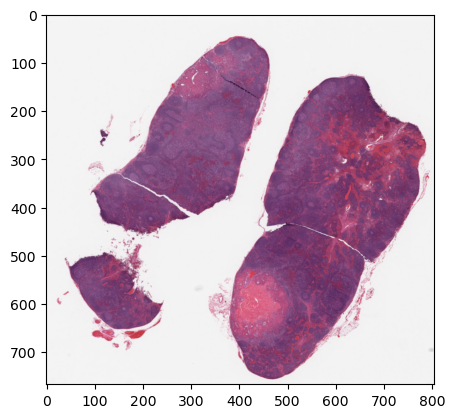

In [3]:
src_dir = "/mnt/d/SynologyDrive/SRI_OSCC_lymph_labeled" # WSL
#src_dir = "/mnt/voyage/Datasets_pathology/SRI_OSCC_lymph_labeled" # Linux
#src_dir = "/mnt/FNX/SynologyDrive/Datasets_pathology/SRI_OSCC_lymph_test/" #FN Linux
image_id = "Case 14 F11"
image_ext = ".svs"
image_file = os.path.join(src_dir, image_id+image_ext)
max_dim = 800
# Read WSI header and get some info
with tf.TiffFile(image_file) as slide:
    print(
        f"This image has {len(slide.pages)} pages, {len(slide.series[0].levels)} levels:"
    )
    for i in slide.series[0].levels:
        print(i.shape)
    # Get image thumbnail
    image_thumbnail = train_utils.TrainUtil(max_dim).find_top(slide)
    # Set image dimension attributes
    target_dim = image_thumbnail.shape
    base_dim = slide.series[0].levels[0].shape
    base_dim = train_utils.channel_last(base_dim)
    # Display image
    fig, ax = plt.subplots()
    ax.imshow(image_thumbnail)
    plt.show(); plt.close()

### Inference using LesionFinder model (based on ROI_detection2 faster-RCNN)

In [ ]:
# Load trained model from config and weights
cfg = get_cfg()
add_ubteacher_config(cfg)
cfg.set_new_allowed(True)
cfg.PARENTDIR = ""
# LesionFinder model
cfg.merge_from_file("../completed_outputs/COCOPath_Pretraining_1005/config-backup.yaml")
cfg.MODEL.WEIGHTS = "../completed_outputs/COCOPath_Pretraining_1005/model_0199999.pth"
model = build_model(cfg)
model.eval()
checkpointer = DetectionCheckpointer(model)
checkpointer.load(cfg.MODEL.WEIGHTS)

### Inference using TissueFinderV2.2 model (based on ubteacher faster-RCNN)

In [12]:
# Load trained model from config and weights
cfg = get_cfg()
add_ubteacher_config(cfg)
cfg.set_new_allowed(True)
cfg.PARENTDIR = ""
# TissueFinderV2.2 model
cfg.merge_from_file("../completed_outputs/TissueFinderV2.2/config.yaml")
cfg.MODEL.WEIGHTS = "../completed_outputs/TissueFinderV2.2/model_final.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
if cfg.SEMISUPNET.Trainer == "ubteacher":
        Trainer = UBTeacherTrainer
elif cfg.SEMISUPNET.Trainer == "ubteacher_rcnn":
    Trainer = UBRCNNTeacherTrainer
else:
    raise ValueError("Trainer Name is not found.")
model = Trainer.build_model(cfg)
model_teacher = Trainer.build_model(cfg)
ensem_ts_model = EnsembleTSModel(model_teacher, model)
DetectionCheckpointer(ensem_ts_model
).resume_or_load(cfg.MODEL.WEIGHTS, resume=False)
#res = Trainer.test(cfg, ensem_ts_model.modelTeacher)
ensem_ts_model.eval()

EnsembleTSModel(
  (modelTeacher): TwoStagePseudoLabGeneralizedRCNN(
    (backbone): FPN(
      (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
      (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
      (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
      (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
      (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (top_block): LastLevelMaxPool()
      (bottom_up): ResNet(
        (stem): BasicStem(
          (conv1): Conv2d(
            3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
            (norm): FrozenBatchNorm2d(num_features=64, e

In [10]:
# Load trained model from config and weights
cfg = get_cfg()
add_ubteacher_config(cfg)
cfg.set_new_allowed(True)
cfg.PARENTDIR = ""
# TissueFinderV2.2 model
cfg.merge_from_file("../completed_outputs/TissueFinderV2.2/config.yaml")
cfg.MODEL.WEIGHTS = "../completed_outputs/TissueFinderV2.2/model_final.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

if cfg.SEMISUPNET.Trainer == "ubteacher":
        Trainer = UBTeacherTrainer
elif cfg.SEMISUPNET.Trainer == "ubteacher_rcnn":
    Trainer = UBRCNNTeacherTrainer
else:
    raise ValueError("Trainer Name is not found.")

if cfg.SEMISUPNET.Trainer == "ubteacher":
    model = Trainer.build_model(cfg)
    model_teacher = Trainer.build_model(cfg)
    ensem_ts_model = EnsembleTSModel(model_teacher, model)
    DetectionCheckpointer(ensem_ts_model
    ).resume_or_load(cfg.MODEL.WEIGHTS, resume=False)
    #res = Trainer.test(cfg, ensem_ts_model.modelTeacher)
    ensem_ts_model.eval()

else:
    model = Trainer.build_model(cfg)
    checkpointer = Trainer.checkpointer
    checkpointer.load(cfg.MODEL.WEIGHTS)
    #res = Trainer.test(cfg, model)
    model.eval()
#model = build_model(cfg)
#model.eval()
#checkpointer = DetectionCheckpointer(model)
#checkpointer.load(cfg.MODEL.WEIGHTS)
#predictor = DefaultPredictor(cfg)

AttributeError: type object 'UBRCNNTeacherTrainer' has no attribute 'checkpointer'

In [13]:
original_image = image_thumbnail[:, :, ::-1]
height, width = original_image.shape[:2]
image = torch.as_tensor(original_image.astype("float32").transpose(2, 0, 1))
image.to(cfg.MODEL.DEVICE)

inputs = {"image": image, "height": height, "width": width}

In [17]:
#with torch.no_grad():
#    outputs = predictor(image_thumbnail)
with torch.no_grad():
    outputs = ensem_ts_model.modelStudent([inputs])[0]
instances = outputs["instances"].to("cpu")
instances.get_fields()

{'pred_boxes': Boxes(tensor([[375.4283, 100.0132, 790.5706, 737.1776],
         [ 83.4896,  37.3276, 478.4603, 452.3243],
         [ 37.2308, 471.3470, 249.8839, 676.1054]])),
 'scores': tensor([0.9312, 0.9041, 0.7369]),
 'pred_classes': tensor([0, 0, 0]),
 'pred_boxes_std': tensor([[-1.3373, -2.0487, -1.9728, -1.2225],
         [-1.4503, -1.4382, -1.9354, -1.3699],
         [-1.4814, -0.7310, -1.6708, -0.9931]])}

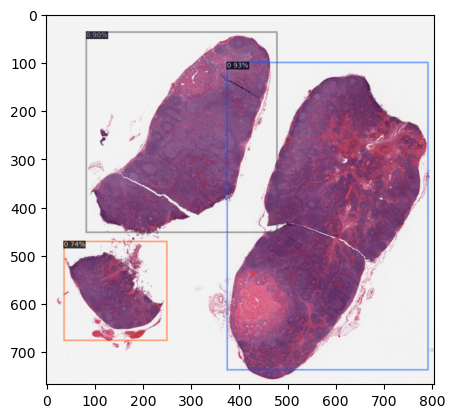

In [18]:
v = Visualizer(image_thumbnail[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1)
v = v.draw_instance_predictions(instances)
plt.imshow(v.get_image()[:, :, ::-1])
plt.show(); plt.close()